In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_env import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
from dynamics_env.galaxy_models import PointSource
from scipy.integrate import solve_ivp

In [2]:
episode_length = 2048
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]

# init_params = [0.48813504, 2.15189366, 1.02763376, 0.1, 0, 0]
memory_size = 1e4
lookahead_options = 4
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
weights_directory = 'runs/Dynamics-v0__point_source__0_weights/'
lookahead_steps = 4
gamma = 0.98
M = 10

In [3]:
source = PointSource(M)
def get_equations(t, w):
    x, y, z, vx, vy, vz = w
    ax, ay, az = source.get_acceleration(np.array([x, y, z]))
    return [vx, vy, vz, ax.item(), ay.item(), az.item()]
test_orbit = solve_ivp(get_equations, t_span=(0, 100), y0=init_params, t_eval=np.linspace(0, 100, 1000)).y[:]

def denorm_state(state):
    return state*env.high

Text(0.5, 0.92, '3D Orbit')

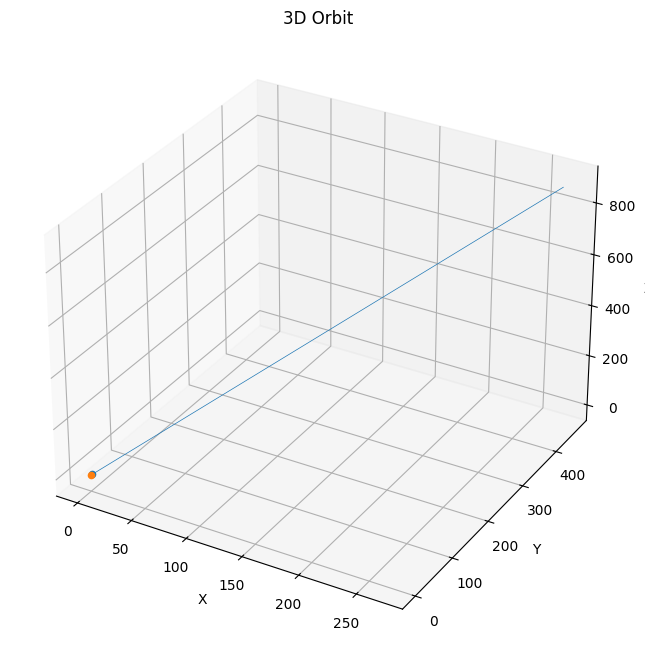

In [4]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(test_orbit[0], test_orbit[1], test_orbit[2], lw=0.5)
ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
ax1.scatter(0, 0, 0, label='Source')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Orbit')

In [5]:
class DynamicsModel(torch.nn.Module):
    def __init__(self, env, hidden_dim=64):
        super().__init__()
        input_dim = env.observation_space.shape[0] + env.action_space.shape[0]
        output_dim = env.observation_space.shape[0]
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim * 2)
        )
        self.output_dim = output_dim
        self.trajectories = []
        self.rtgs = []
        self.stds = []
        self.confidence_network = torch.nn.Sequential(
            torch.nn.Linear((output_dim + 1) * lookahead_options, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, lookahead_options + 1),
        )
        self.softmax = torch.nn.Softmax(dim=0)
        
    def forward(self, x, y):
        x = self.model(x)
        means, logstds = torch.split(x, [self.output_dim, self.output_dim], dim=-1)
        loss = (((y - means) ** 2) / (2 * torch.exp(logstds) ** 2)) + logstds
        return loss.mean()
    
    def get_prediction(self, x):
        x = self.model(x)
        means, logstds = torch.split(x, [self.output_dim, self.output_dim], dim=-1)
        return means, logstds
    
    def reset(self):
        self.trajectories = []
        self.rtgs = []
        self.stds = []

    def select_action(self):
        rtgs = torch.stack(self.rtgs)
        stds = torch.stack(self.stds)
        x = torch.cat([rtgs, stds], dim=-1)
        scores = self.confidence_network(x.flatten())
        probabilities = self.softmax(scores)
        _, most_probable_action = torch.max(probabilities), torch.argmax(probabilities)
        return (most_probable_action, 0) if most_probable_action < lookahead_options else (np.random.randint(low=0, high=lookahead_options), 1)
    
    def confidence_forward(self, episode_rtgs, episode_stds):
        x = torch.cat([episode_rtgs.unsqueeze(-1), episode_stds], dim=-1)
        x = x.flatten(start_dim=1, end_dim=2)
        episode_scores = self.confidence_network(x)
        episode_preferred_actions, _ = torch.max(episode_scores, dim=-1) # (n_steps,)
        return episode_preferred_actions.flatten()

class Memory():
    def __init__(self, env):
        self.source_state_action = None
        self.dest_state = None
        self.rtgs = None
        self._observations_shape = env.observation_space.shape[0]
        self._actions_shape = env.action_space.shape[0]

    def get_mapped_pairs(self):
        return self.source_state_action, self.dest_state

class BestMemory(Memory):
    def __init__(self, env):
        super().__init__(env)

    def add(self, observations, actions, rtgs):
        if self.rtgs == None:
            self.source_state_action = torch.cat([observations[:-1], actions[:-1]],dim=1)
            self.dest_state = observations[1:]
            self.rtgs = rtgs[:-1]
            self.rtgs, sorted_indices = torch.sort(self.rtgs, descending=True)
            self.source_state_action = self.source_state_action[sorted_indices]
            self.dest_state = self.dest_state[sorted_indices]
            return
        
        # forget
        forget_mask = torch.ones_like(self.rtgs) * (torch.rand(self.rtgs.shape).to(device) > 0.01)
        self.rtgs *= forget_mask
        self.rtgs, sorted_indices = torch.sort(self.rtgs, descending=True)
        self.source_state_action = self.source_state_action[sorted_indices]
        self.dest_state = self.dest_state[sorted_indices]

        # already descending sorted
        source_state_action = torch.cat([observations[:-1], actions[:-1]],dim=1)
        dest_state = observations[1:]
        rtgs = rtgs[:-1]
        rtgs, sorted_indices = torch.sort(rtgs, descending=True)
        source_state_action = source_state_action[sorted_indices]
        dest_state = dest_state[sorted_indices]
        # merge sorting
        source_list_1_indices, source_list_2_indices = self.merge_sort(self.rtgs, rtgs)
        merged_source_state_action = torch.zeros(len(source_state_action)+len(self.source_state_action),self._observations_shape+self._actions_shape).to(device)
        merged_source_state_action[source_list_1_indices] = self.source_state_action
        merged_source_state_action[source_list_2_indices] = source_state_action

        merged_dest_state = torch.zeros(len(dest_state)+len(self.dest_state),self._observations_shape).to(device)
        merged_dest_state[source_list_1_indices] = self.dest_state
        merged_dest_state[source_list_2_indices] = dest_state

        merged_rtgs = torch.zeros(len(rtgs)+len(self.rtgs)).to(device)
        merged_rtgs[source_list_1_indices] = self.rtgs
        merged_rtgs[source_list_2_indices] = rtgs

        self.source_state_action = merged_source_state_action[:memory_size]
        self.dest_state = merged_dest_state[:memory_size]
        self.rtgs = merged_rtgs[:memory_size]

    def merge_sort(self, sorted_list_1, sorted_list_2):
        source_list_1_indices = []
        source_list_2_indices = []
        i, j, k = 0, 0, 0
        while(i < len(sorted_list_1) and j < len(sorted_list_2)):
            if sorted_list_1[i] > sorted_list_2[j]:
                source_list_1_indices.append(k)
                i += 1
                k += 1
            else:
                source_list_2_indices.append(k)
                j += 1
                k += 1
        while(i < len(sorted_list_1)):
            source_list_1_indices.append(k)
            i += 1
            k += 1
        while(j < len(sorted_list_2)):
            source_list_2_indices.append(k)
            j += 1
            k += 1
        return source_list_1_indices, source_list_2_indices
    
class RecentMemory(Memory):
    def __init__(self, env):
        super().__init__(env)

    def add(self, observations, actions):
        if self.source_state_action == None:
            self.source_state_action = torch.cat([observations[:-1], actions[:-1]],dim=1)
            self.dest_state = observations[1:]
            return
        source_state_action = torch.cat([observations[:-1], actions[:-1]],dim=1)
        dest_state = observations[1:]
        self.source_state_action = torch.cat([self.source_state_action, source_state_action], dim=0)
        self.dest_state = torch.cat([self.dest_state, dest_state], dim=0)
        if len(self.dest_state) > memory_size:
            self.dest_state = self.dest_state[len(self.dest_state) - memory_size:]
            self.source_state_action = self.source_state_action[len(self.source_state_action) - memory_size:]

class MemoryMixer():
    def __init__(self, env):
        self.best_memory = BestMemory(env)
        self.recent_memory = RecentMemory(env)
    
    def add(self, observations, actions, rtgs):
        self.best_memory.add(observations, actions, rtgs)
        self.recent_memory.add(observations, actions)
    
    def get_mapped_pairs(self):
        best_sa, best_d = self.best_memory.get_mapped_pairs()
        recent_sa, recent_d = self.recent_memory.get_mapped_pairs()
        return torch.cat([best_sa, recent_sa], dim=0), torch.cat([best_d, recent_d], dim=0)

def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, input): return mish(input)

# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, env, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, env.action_space.shape[0] * 2)
        )
        self.split_shape = env.action_space.shape[0]
    def forward(self, X):
        X = self.model(X)
        (means, log_stds) = torch.split(X, [self.split_shape, self.split_shape], dim=-1)
        return means, log_stds.exp()
    
# Critic module
class Critic(nn.Module):
    def __init__(self, env, activation=nn.Tanh):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 64),
            activation(),
            nn.Linear(64, 32),
            activation(),
            nn.Linear(32, 1)
        )

    def forward(self, X):
        return self.model(X)

def make_env(gym_id, seed):
    def thunk():
        # env = gym.make(gym_id, hyperparameters={
        #     'galaxy_model_kwargs_list':[{'M':10}]
        # })
        env = Dynamics(hyperparameters={
            'galaxy_model_kwargs_list':[{'M':M}],
            'seed':seed,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

In [6]:
env = make_env(None, seed=seed)()
actor = Actor(env, activation=Mish).to(device)
critic = Critic(env, activation=Mish).to(device)
theory = DynamicsModel(env).to(device)
memory = MemoryMixer(env)
actor.load_state_dict(torch.load(weights_directory+f'actor_{seed}.pth'))
critic.load_state_dict(torch.load(weights_directory+f'critic_{seed}.pth'))
theory.load_state_dict(torch.load(weights_directory+f'theory_{seed}.pth'))
env.reset(init_params=init_params)
observations = np.zeros((episode_length,)+env.observation_space.shape)
state, _ = env.reset_2()
for i in tqdm(range(int(episode_length))):
    state = torch.tensor(state, dtype=torch.float32, device=device)
    with torch.no_grad():
        action_means, action_stds = actor(state)
        value = critic(state).flatten()
    dist = torch.distributions.Normal(action_means, action_stds)
    theory.reset()
    for l_o in range(lookahead_options):
        for l_i in range(lookahead_steps):
            if l_i == 0:
                lookahead_action = dist.sample()
                with torch.no_grad():
                    projected_state, previous_stds = theory.get_prediction(torch.cat([state, lookahead_action]))
                    previous_discounted_reward = critic(projected_state) - critic(state)
                lookahead_actions = [lookahead_action]
            else:
                with torch.no_grad():
                    action_means, action_stds = actor(projected_state)
                dist_ = torch.distributions.Normal(action_means, action_stds)
                lookahead_action = dist_.sample()
                with torch.no_grad():
                    projected_state, stds = theory.get_prediction(torch.cat([projected_state, lookahead_action]))
                    projected_discounted_reward = (gamma ** l_i) * (critic(projected_state) - critic(state))
                previous_discounted_reward += projected_discounted_reward
                previous_stds += stds
                lookahead_actions.append(lookahead_action)
        theory.trajectories.append(lookahead_actions)
        theory.rtgs.append(previous_discounted_reward)
        theory.stds.append(previous_stds)

    with torch.no_grad():
        selected_action_index, random_selection_or_not = theory.select_action()
    action = theory.trajectories[selected_action_index][0]
    observations[i] = state.numpy()
    state, reward, done, _, info = env.step_2(action.cpu().numpy())
    if done: 
        done_index = i
        break

[ENV] Seed set to 0


  3%|▎         | 55/2048 [00:00<00:13, 147.90it/s]


In [7]:
orbit2 = env.orbit.y[:]
orbit = env.orbit.y[:,:done_index]
observations = denorm_state(observations[:done_index])

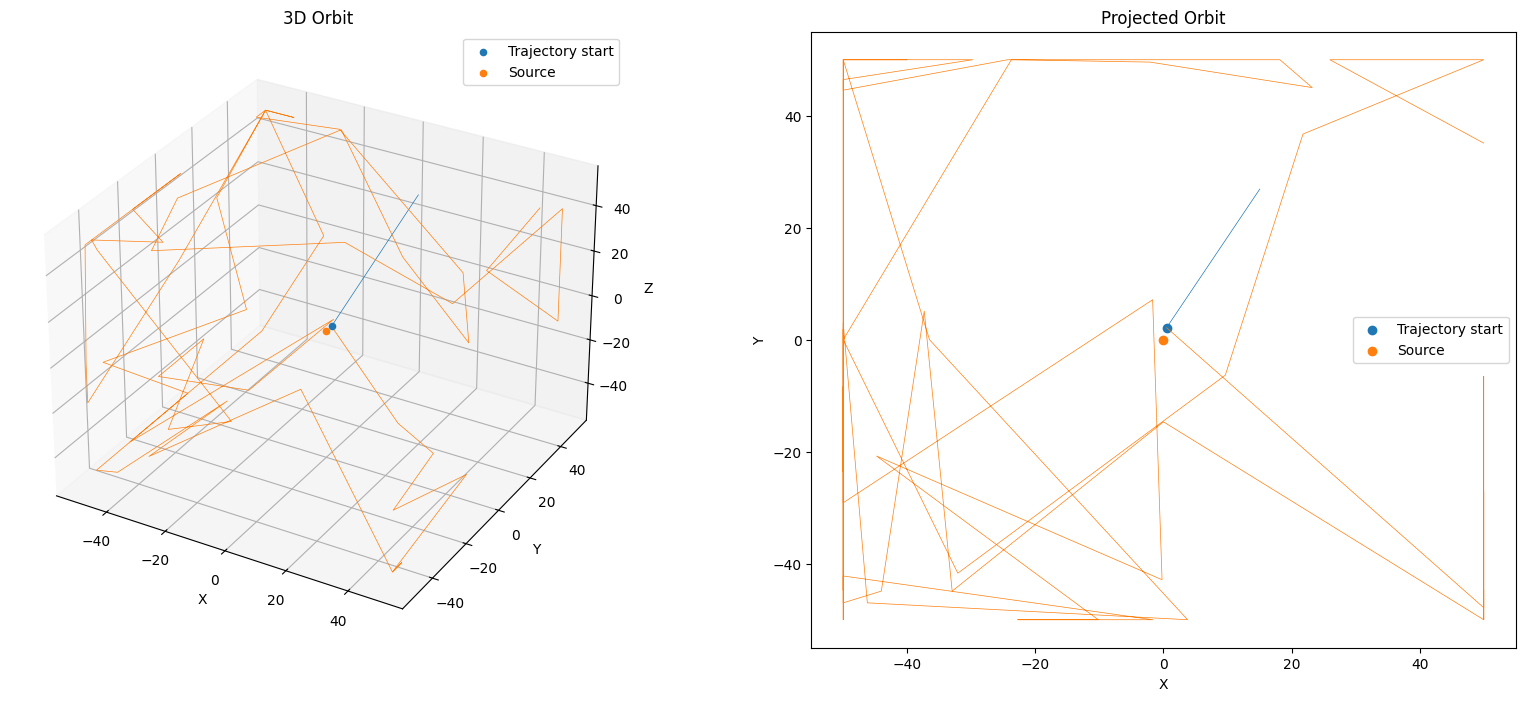

In [8]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(orbit[0], orbit[1], orbit[2], lw=0.5)
ax1.plot(observations[:,0], observations[:,1], observations[:,2], lw=0.5)
ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
ax1.scatter(0, 0, 0, label='Source')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Orbit')

ax2 = fig.add_subplot(122)
ax2.plot(orbit[0], orbit[1], lw=0.5)
ax2.plot(observations[:,0], observations[:,1], lw=0.5)
ax2.scatter(init_params[0], init_params[1], label='Trajectory start')
ax2.scatter(0, 0, label='Source')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Projected Orbit')

ax1.legend()
ax2.legend()
plt.show()